<a href="https://colab.research.google.com/github/somoon0422/ML_project_2-/blob/model_code/v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <신장 종양 적출에 따른 손실체적(RAIV) 예측>

신장 종양 평가지표(PADUA, Renal..)를 활용한 최소한의 필요한 종양 적출 체적 예측 <br>
과거에는 신장에 발생한 악성종양을 제거할 때 한쪽 신장을 모두 제거하는 것이 문제가 없는 것으로 인식됐었으나, 최근에는 신장 한쪽을 제거한 경우 수술 후 신부전·심혈관질환 각종 대사성 질환의 빈도가 증가한다는 보고가 있어 가능하면 신장을 보존하는 것이 추천되는 경향
신장은 출혈 위험이 크며, 생명 유지에 중요한 기능을 하는 장기이므로 신장의 기능을 보존할 수 있게 신장 수술의 목표는 최소 절개 및 최대 보존
신장을 최대한 보존해 합병증을 줄임으로써 중요한 만성질환 예방과 삶의 질을 높여 환자들에게 큰 도움이 될 것

### data

- T_surface_loc : 종양의 표면 위치 <br>
- T_sinus_dt : 종양의 신동과의 거리 <br>
- T_height_loc : 종양의 세로 기준 위치 <br>
- T_gm_over : 종양의 사구체 침범 정도 <br>
- T_size : 종양의 크기 <br>
- T_Exophytic : 외성장비율 <br>
- T_near_urethra : 종양과 요도의 근접 정도 <br>
- T_rel_urethra : 종양의 요도 기준 상대 위치 <br>
- T_APX : 종양의 위치 - 전/후방(숫자) <br>

- 'serial' : 환자번호
- 'RAIV_1' : 손실체적(cm^3)


# 1. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from model import *
from sklearn.tree import plot_tree

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
padua = pd.read_csv('./data/kideny_PADUA_upload.csv')
renal = pd.read_csv('./data/kideny_RENAL_upload.csv')
treat = pd.read_csv('./data/kidney_treat_upload.csv')

In [3]:
padua.head()

,serial,Tumor_PADUA,Exophytic_PADUA,Rim_PADUA,Sinus_PADUA,Polarlocation_PADUA,Collectingsystem_PADUA,PADUA_total
0,1,2.0,1.0,2.0,1.0,1.0,1.0,8
1,2,1.0,2.0,1.0,1.0,2.0,1.0,8
2,3,1.0,1.0,1.0,1.0,2.0,1.0,7
3,4,1.0,1.0,1.0,1.0,2.0,2.0,8
4,5,1.0,2.0,1.0,1.0,2.0,1.0,8


In [4]:
renal.head()

,serial,Radius_RENAL,Exophytic_RENAL,Nearness_RENAL,APX_RENAL,Location_RENAL,RENAL_total
0,1,2.0,1.0,1.0,2.0,1.0,4
1,2,1.0,2.0,2.0,2.0,2.0,5
2,3,1.0,1.0,1.0,1.0,1.0,3
3,4,1.0,1.0,3.0,2.0,3.0,5
4,5,1.0,2.0,1.0,1.0,3.0,4


In [5]:
treat.head()

,serial,RAIV_1
0,1,51.1
1,2,46.1
2,3,14.8
3,4,19.7
4,5,14.8


# 2. 데이터 정리
중복 컬럼 삭제(종양의 크기, 외성장 비율) 및 데이터 합치기

In [6]:
merged_data = pd.merge(padua, renal, on='serial')
# padua 에서 중복 컬럼 삭제
merged_data = merged_data.drop(['Tumor_PADUA', 'Exophytic_PADUA'], axis=1)
# treat 데이터 merge
merged_result = pd.merge(merged_data, treat, on='serial', how='left')
# serial을 인덱스로 설정
merged_result.set_index('serial', inplace=True)

In [7]:
merged_result

,Rim_PADUA,Sinus_PADUA,Polarlocation_PADUA,Collectingsystem_PADUA,PADUA_total,Radius_RENAL,Exophytic_RENAL,Nearness_RENAL,APX_RENAL,Location_RENAL,RENAL_total,RAIV_1
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,8,2.0,1.0,1.0,2.0,1.0,4,51.1
2,1.0,1.0,2.0,1.0,8,1.0,2.0,2.0,2.0,2.0,5,46.1
3,1.0,1.0,2.0,1.0,7,1.0,1.0,1.0,1.0,1.0,3,14.8
4,1.0,1.0,2.0,2.0,8,1.0,1.0,3.0,2.0,3.0,5,19.7
5,1.0,1.0,2.0,1.0,8,1.0,2.0,1.0,1.0,3.0,4,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,1.0,2.0,1.0,8,1.0,2.0,1.0,1.0,3.0,4,21.3
409,1.0,1.0,2.0,1.0,8,1.0,2.0,1.0,1.0,3.0,4,30.5
410,1.0,1.0,1.0,1.0,7,1.0,2.0,1.0,1.0,1.0,4,70.7


## 컬럼명 변경 , 순서 재정렬

In [8]:
# RAIV_1 -> RAIV
merged_result = merged_result.rename(columns={'Radius_RENAL': 'T_size', 'Exophytic_RENAL':'T_Exophytic',
                            'Rim_PADUA':'T_surface_loc','Polarlocation_PADUA':'T_height_loc',
                            'Collectingsystem_PADUA':'T_gm_over','Sinus_PADUA':'T_sinus_dt',
                            'Nearness_RENAL':'T_near_ureter','APX_RENAL':'T_APX','Location_RENAL':'T_rel_ureter','RAIV_1': 'RAIV'
                            })
merged_result = merged_result[['T_surface_loc', 'T_sinus_dt', 'T_height_loc', 'T_gm_over', 'T_size', 'T_Exophytic', 'T_near_ureter', 'T_rel_ureter', 'T_APX', 'PADUA_total', 'RENAL_total', 'RAIV']]
merged_result

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_ureter,T_rel_ureter,T_APX,PADUA_total,RENAL_total,RAIV
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,8,4,51.1
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,8,5,46.1
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,7,3,14.8
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,8,5,19.7
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,8,4,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,8,4,21.3
409,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,8,4,30.5
410,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,7,4,70.7


- PADUA_total , RENAL_total 삭제
- 하나의 total 점수생성

In [9]:
merged_result['Total'] = merged_result[['T_surface_loc', 'T_sinus_dt', 'T_height_loc', 'T_gm_over', 'T_size', 'T_Exophytic', 'T_near_ureter', 'T_rel_ureter', 'T_APX']].sum(axis=1)
merged_result.drop(columns=['PADUA_total', 'RENAL_total'], inplace=True)

merged_result.head()

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_ureter,T_rel_ureter,T_APX,RAIV,Total
serial,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,51.1,12.0
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,46.1,14.0
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,14.8,10.0
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,19.7,16.0
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,14.8,13.0


## 결측치 삭제

In [10]:
merged_result = merged_result.dropna()
merged_result

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_ureter,T_rel_ureter,T_APX,RAIV,Total
serial,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,51.1,12.0
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,46.1,14.0
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,14.8,10.0
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,19.7,16.0
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,14.8,13.0
...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,21.3,13.0
409,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,30.5,13.0
410,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,70.7,10.0


In [11]:
# 새로운 컬럼(T_size + T_Exophytic = T_size_exo )
merged_result['T_size_exo'] = merged_result['T_size'] + merged_result['T_Exophytic']

C:\Users\rbfl7\AppData\Local\Temp\ipykernel_17128\4263335986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_result['T_size_exo'] = merged_result['T_size'] + merged_result['T_Exophytic']


In [12]:
merged_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 389 entries, 1 to 412
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_surface_loc  389 non-null    float64
 1   T_sinus_dt     389 non-null    float64
 2   T_height_loc   389 non-null    float64
 3   T_gm_over      389 non-null    float64
 4   T_size         389 non-null    float64
 5   T_Exophytic    389 non-null    float64
 6   T_near_ureter  389 non-null    float64
 7   T_rel_ureter   389 non-null    float64
 8   T_APX          389 non-null    float64
 9   RAIV           389 non-null    float64
 10  Total          389 non-null    float64
 11  T_size_exo     389 non-null    float64
dtypes: float64(12)
memory usage: 39.5 KB


# 3. 데이터 탐색(EDA)

In [13]:
merged_result.head()

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_ureter,T_rel_ureter,T_APX,RAIV,Total,T_size_exo
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,51.1,12.0,3.0
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,46.1,14.0,3.0
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,14.8,10.0,2.0
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,19.7,16.0,2.0
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,14.8,13.0,3.0


## 각 변수들의 분포도 시각화

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a grid of subplots, 3 columns wide
fig = make_subplots(rows=4, cols=3, subplot_titles=merged_result.columns)

# Iterate through each variable and create a histogram for it
for i, col in enumerate(merged_result.columns):
    hist_trace = go.Histogram(x=merged_result[col])
    fig.add_trace(hist_trace, row=i // 3 + 1, col=i % 3 + 1)

# Update layout
fig.update_layout(height=600, width=900, title_text="Histograms of Variables")

# Show plot
fig.show()


# 규리
# # 분포확인( 범주형 데이터 )
# merged_corr = merged_result.drop(['serial'], axis=1)
# merged_corr.hist(bins=10, figsize=(15,10))
# plt.show()


## 상관관계

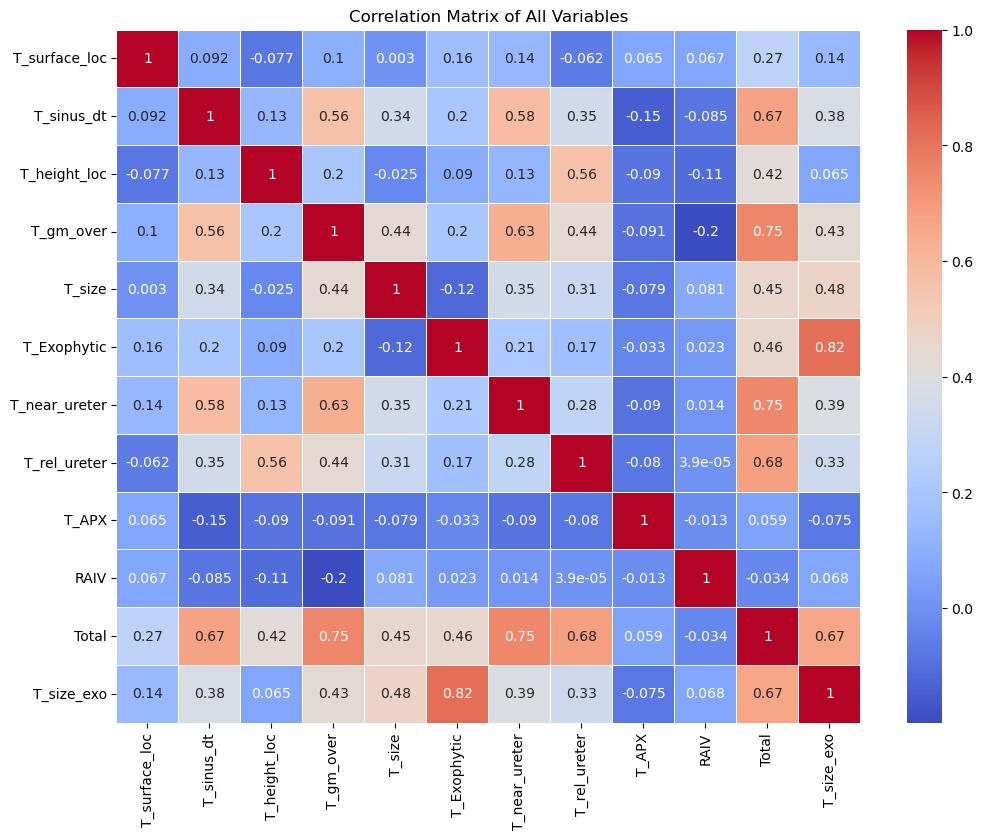

In [15]:
# Get all numeric columns
numeric_columns = merged_result.select_dtypes(include=['int64', 'float64']).columns

# Create a correlation matrix
correlation_matrix = merged_result[numeric_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, cmap="coolwarm")
plt.title("Correlation Matrix of All Variables")
plt.show()


## boxplot

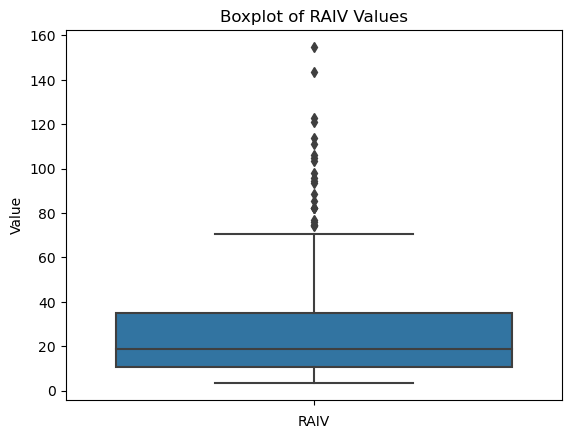

In [16]:
# Create a boxplot of the RAIV_1 variable
sns.boxplot(data=merged_result, y="RAIV")

# Add a title and labels
plt.title("Boxplot of RAIV Values")
plt.xlabel("RAIV")
plt.ylabel("Value")

# Show the plot
plt.show()



## 이상치와 아닌 데이터의 total 점수를 비교
x축에는 전체데이터의 RAIV, y축은 Total <br>

In [17]:
import plotly.graph_objects as go

# Filter merged_result based on RAIV_1 >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV_1 < 80
trace_raiv_lt_80 = go.Scatter(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['Total'],
    mode='markers',
    name='RAIV < 80'
)

# Create a scatter plot for RAIV_1 >= 80
trace_raiv_gte_80 = go.Scatter(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['Total'],
    mode='markers',
    name='RAIV >= 80'
)

# Create layout
layout = go.Layout(
    title="Scatter Plot of Total Scores vs RAIV",
    xaxis=dict(title='RAIV'),
    yaxis=dict(title='Total')
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()


## T_Exophytic , RAIV 을 2차원으로 확인

In [18]:
import plotly.graph_objects as go

# Filter merged_result based on RAIV >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV < 80
trace_raiv_lt_80 = go.Scatter(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['T_Exophytic'],
    mode='markers',
    name='RAIV < 80'
)

# Create a scatter plot for RAIV >= 80
trace_raiv_gte_80 = go.Scatter(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['T_Exophytic'],
    mode='markers',
    name='RAIV >= 80'
)

# Create layout
layout = go.Layout(
    title="Scatter Plot of T_Exophytic vs RAIV",
    xaxis=dict(title='RAIV'),
    yaxis=dict(title='T_Exophytic')
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()


## T_size, T_Exophytic , RAIV을 3차원으로 확인

In [19]:
import plotly.graph_objects as go

# Filter merged_result based on RAIV >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV < 80
trace_raiv_lt_80 = go.Scatter3d(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['T_Exophytic'],
    z=merged_result[merged_result['RAIV'] < 80]['T_size'],
    mode='markers',
    name='RAIV < 80',
    marker=dict(size=5)
)

# Create a scatter plot for RAIV >= 80
trace_raiv_gte_80 = go.Scatter3d(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['T_Exophytic'],
    z=merged_result_raiv_80['T_size'],
    mode='markers',
    name='RAIV >= 80',
    marker=dict(size=5)
)

# Create layout
layout = go.Layout(
    title="3D Scatter Plot of T_Exophytic and T_size vs RAIV",
    scene=dict(
        xaxis=dict(title='RAIV'),
        yaxis=dict(title='T_Exophytic'),
        zaxis=dict(title='T_size')
    )
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()


**결론: T_size는 RAIV값에 큰 영향을 끼치는 것 같지가 않다.**

## T_near_ureter , T_Exophytic , RAIV 값을 3차원으로 확인

In [20]:
import plotly.graph_objects as go

# Filter merged_result based on RAIV >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV < 80
trace_raiv_lt_80 = go.Scatter3d(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['T_Exophytic'],
    z=merged_result[merged_result['RAIV'] < 80]['T_near_ureter'],
    mode='markers',
    name='RAIV < 80',
    marker=dict(size=5)
)

# Create a scatter plot for RAIV >= 80
trace_raiv_gte_80 = go.Scatter3d(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['T_Exophytic'],
    z=merged_result_raiv_80['T_near_ureter'],
    mode='markers',
    name='RAIV >= 80',
    marker=dict(size=5)
)

# Create layout
layout = go.Layout(
    title="3D Scatter Plot of T_Exophytic and T_near_ureter vs RAIV",
    scene=dict(
        xaxis=dict(title='RAIV'),
        yaxis=dict(title='T_Exophytic'),
        zaxis=dict(title='T_near_ureter')
    )
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()


**결론: 오히려 T_size 보다 T_near_urethra 가 유의미한 데이터로 보임**

## 새로운데이터 T_size_exo , RAIV 값을 2차원으로 확인

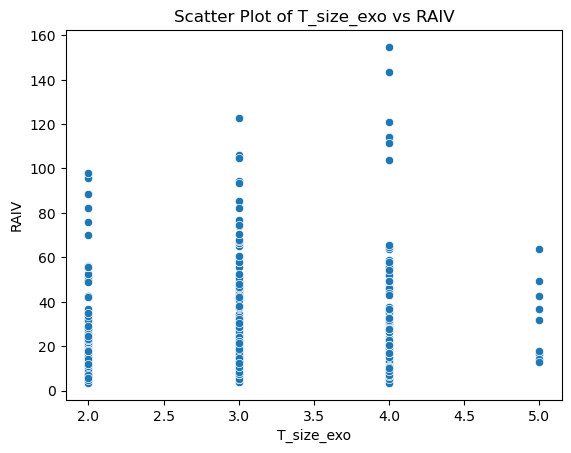

In [21]:
# Create a scatter plot of T_size_exo vs RAIV
sns.scatterplot(data=merged_result, x="T_size_exo", y="RAIV")

# Add a title and labels
plt.title("Scatter Plot of T_size_exo vs RAIV")
plt.xlabel("T_size_exo")
plt.ylabel("RAIV")

# Show the plot
plt.show()



## 이상치제거X : merged_result 사용 / 단, 원본은 남겨두고 merged_copy라는 변수로 사용하길 권장 (v1버전)
## 이상치제거O : merged_data_80이라는 변수를 제거한 merged_drop 을 사용하세요 (아래에 생성해둠) (v2버전)


RAIV가 80이상인 데이터 따로 변수에 할당해줌

In [22]:
merged_data_80 = merged_result[merged_result['RAIV'] > 80]
merged_data_80

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_ureter,T_rel_ureter,T_APX,RAIV,Total,T_size_exo
serial,,,,,,,,,,,,
11,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,95.7,11.0,2.0
16,1.0,2.0,1.0,1.0,1.0,2.0,3.0,1.0,2.0,85.4,14.0,3.0
19,2.0,1.0,2.0,1.0,1.0,3.0,1.0,2.0,2.0,114.0,15.0,4.0
22,1.0,2.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0,154.8,14.0,4.0
46,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,94.2,10.0,3.0
50,1.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0,1.0,111.3,13.0,4.0
53,2.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,2.0,103.6,14.0,4.0
60,1.0,1.0,2.0,1.0,1.0,3.0,1.0,3.0,1.0,143.4,14.0,4.0
79,1.0,1.0,2.0,1.0,1.0,2.0,3.0,2.0,2.0,93.6,15.0,3.0


RAIV80이상인 데이터없는 데이터 새로 만들어줌
(merged_data는 살려둠)

## 1. v1 데이터(제거X)

In [23]:
merged_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 389 entries, 1 to 412
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_surface_loc  389 non-null    float64
 1   T_sinus_dt     389 non-null    float64
 2   T_height_loc   389 non-null    float64
 3   T_gm_over      389 non-null    float64
 4   T_size         389 non-null    float64
 5   T_Exophytic    389 non-null    float64
 6   T_near_ureter  389 non-null    float64
 7   T_rel_ureter   389 non-null    float64
 8   T_APX          389 non-null    float64
 9   RAIV           389 non-null    float64
 10  Total          389 non-null    float64
 11  T_size_exo     389 non-null    float64
dtypes: float64(12)
memory usage: 39.5 KB


In [24]:
result_copy = merged_result.copy()
result_copy

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_ureter,T_rel_ureter,T_APX,RAIV,Total,T_size_exo
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,51.1,12.0,3.0
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,46.1,14.0,3.0
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,14.8,10.0,2.0
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,19.7,16.0,2.0
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,14.8,13.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,21.3,13.0,3.0
409,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,30.5,13.0,3.0
410,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,70.7,10.0,3.0


# 04. 데이터 나누기(train_test_split)

In [25]:
from sklearn.model_selection import train_test_split

X = merged_result.drop(['RAIV'], axis=1)  # 'RAIV_1' 열을 제외한 모든 열 선택
y = merged_result['RAIV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---

## DecisionTreeRegressor

In [26]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_dt, best_params_dt = grid_search(X_train, y_train, "DecisionTreeRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_dt = tr_dt(X_train, y_train, **best_params_dt)

# 최적의 모델을 평가합니다
evaluate(best_dt, X_test, y_test)

MAE: 14.649181793226388
RMSE: 21.006825406083397


In [27]:
print(best_model_dt, best_params_dt)

DecisionTreeRegressor(max_depth=7, min_samples_split=30, random_state=13) {'max_depth': 7, 'min_samples_split': 30}


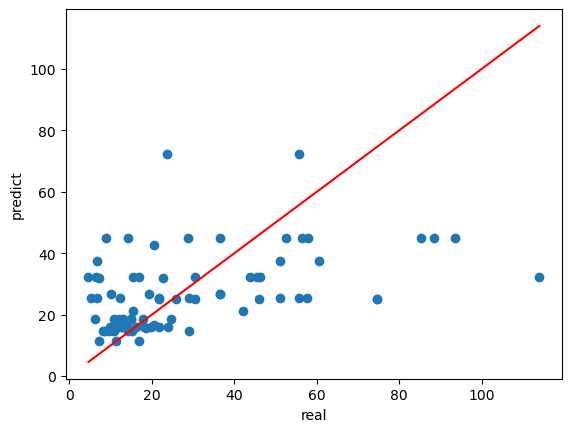

In [28]:
# 최적의 모델을 평가합니다
predictions = best_dt.predict(X_test)

# 산점도를 그립니다
plt.scatter(y_test, predictions)
plt.xlabel('real')
plt.ylabel('predict')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r') 
plt.show()

{'T_surface_loc': 0.010456993526736824, 'T_sinus_dt': 0.00861607850281217, 'T_height_loc': 0.04316685259239187, 'T_gm_over': 0.1340876292723259, 'T_size': 0.19231304630626947, 'T_Exophytic': 0.0, 'T_near_ureter': 0.17426169088737017, 'T_rel_ureter': 0.1895128259079412, 'T_APX': 0.028202027961548432, 'Total': 0.10182515774997271, 'T_size_exo': 0.11755769729263114}


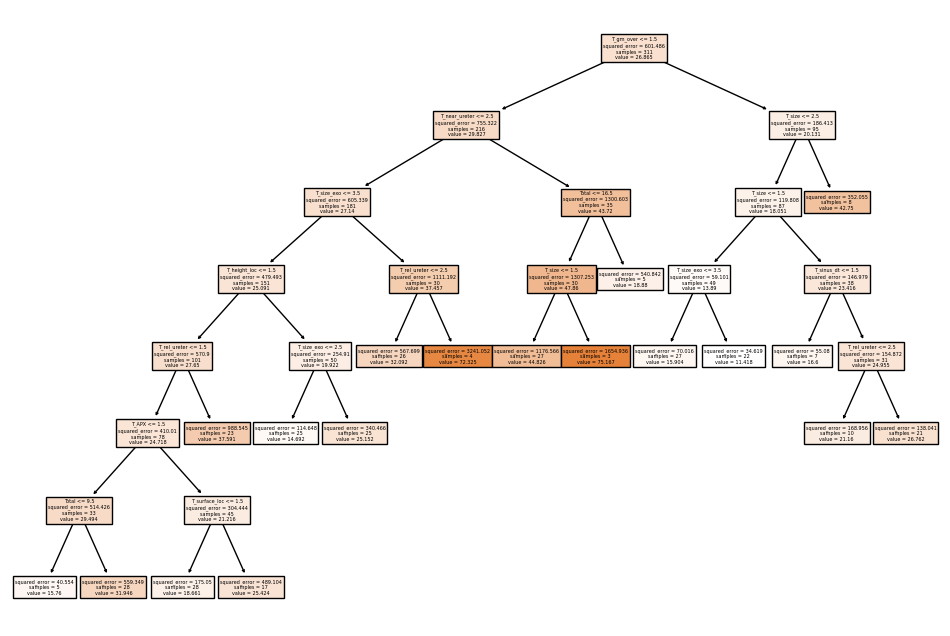

In [29]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 특성 중요도를 확인합니다
feature_importances_dt = best_dt.feature_importances_
importances_dict = dict(zip(X_train.columns, feature_importances_dt))
print(importances_dict)

# 결정 트리를 시각화합니다
plt.figure(figsize=(12, 8))
plot_tree(best_dt, filled=True, feature_names=X.columns.tolist())
plt.show()

In [30]:
# T_size, T_rel_ureter, T_near_ureter, T_gm_over
# 다중선형회귀

In [31]:
from sklearn.linear_model import LinearRegression
import numpy as np

# 중요 특성 선택
X_important_features = merged_result[['T_size', 'T_rel_ureter', 'T_near_ureter', 'T_gm_over']]  # 중요 특성 값들로 이루어진 데이터

# 종속 변수 값
y = merged_result['RAIV']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_important_features, y, test_size=0.2, random_state=42)

# 모델 학습
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 최적의 모델을 평가
evaluate(lr_model, X_test, y_test)

MAE: 15.849179490808938
RMSE: 21.38648226972138


In [32]:
# 다항회귀쓰는 법  -> 특성 선택(feature selection)이나 차원 축소(dimensionality reduction) 기법을 사용하여 알고리즘이 사용할 독립 변수의 수를 제한 / 차수 선택가능
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# 데이터 생성
X = [[1], [2], [3], [4], [5]]  # 독립 변수
y = [2, 3, 5, 6, 5]            # 종속 변수

# 다항 특성 생성
degree = 2  # 다항식의 차수
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

# 모델 학습
model = LinearRegression()
model.fit(X_poly, y)

# 모델 평가 및 활용
# 이후에 새로운 데이터에 대한 예측을 수행하거나 모델을 활용하여 분석을 진행할 수 있습니다.


LinearRegression()

---

## RandomForestRegressor

In [33]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_rf, best_params_rf = grid_search(X_train, y_train, "RandomForestRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델 훈련합니다
best_rf = tr_rf(X_train, y_train, **best_params_rf)

# 최적의 모델을 평가
evaluate(best_rf, X_test, y_test)

MAE: 15.748301670789205
RMSE: 21.295149291723053


In [34]:
print(best_model_rf, best_params_rf)

RandomForestRegressor(max_depth=2, min_samples_split=30, random_state=13) {'max_depth': 2, 'min_samples_split': 30, 'n_estimators': 100}


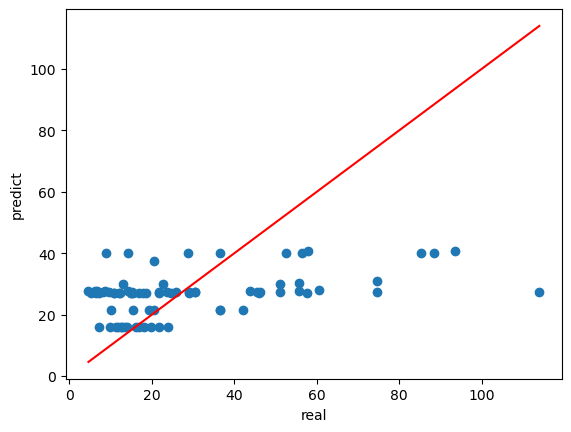

In [35]:
# 최적의 모델을 평가합니다
predictions = best_rf.predict(X_test)

# 산점도를 그립니다
plt.scatter(y_test, predictions)
plt.xlabel('real')
plt.ylabel('predict')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r') 
plt.show()

In [36]:
# 각 특성과 해당 중요도를 딕셔너리 형태로 출력합니다
importances_dict = dict(zip(X_train.columns, best_rf.feature_importances_))
print(importances_dict)

{'T_size': 0.28518789533479855, 'T_rel_ureter': 0.011422853163810144, 'T_near_ureter': 0.3308484186230845, 'T_gm_over': 0.3725408328783068}


In [37]:
# Total, T_near_ureter, T_gm_over, T_rel_ureter
# 다중선형회귀

In [38]:
from sklearn.linear_model import LinearRegression
import numpy as np

# 중요 특성 선택
X_important_features = merged_result[['Total', 'T_near_ureter', 'T_gm_over']]  # 중요 특성 값들로 이루어진 데이터

# 종속 변수 값
y = merged_result['RAIV']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_important_features, y, test_size=0.2, random_state=42)

# 모델 학습
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 최적의 모델을 평가
evaluate(lr_model, X_test, y_test)

MAE: 16.17665028164871
RMSE: 21.525831930409964


---

## KNeighborsRegressor

In [39]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_knn, best_params_knn = grid_search(X_train, y_train, "KNeighborsRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_knn = tr_knn(X_train, y_train, **best_params_knn)

# 최적의 모델을 평가합니다
evaluate(best_knn, X_test, y_test)

MAE: 15.614786324786325
RMSE: 21.031041675583115


In [40]:
print(best_model_knn, best_params_knn)

KNeighborsRegressor(n_neighbors=30) {'n_neighbors': 30, 'weights': 'uniform'}


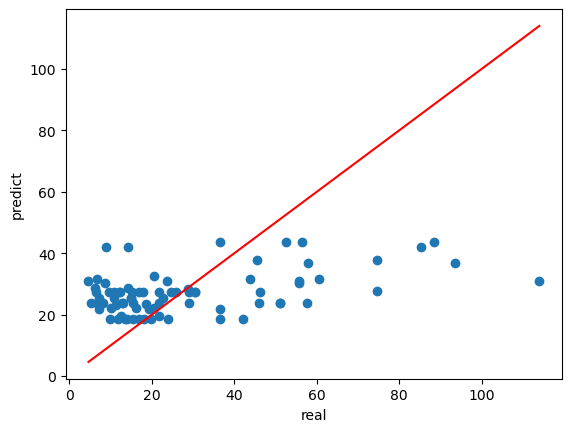

In [41]:
# 최적의 모델을 평가합니다
predictions = best_knn.predict(X_test)

# 산점도를 그립니다
plt.scatter(y_test, predictions)
plt.xlabel('real')
plt.ylabel('predict')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r') 
plt.show()

---

## XGBRegressor

In [42]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_xgb, best_params_xgb = grid_search(X_train, y_train, "XGBRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_xgb = tr_xgb(X_train, y_train, **best_params_xgb)

# 최적의 모델을 평가합니다
evaluate(best_xgb, X_test, y_test)

ValueError: Invalid model name

In [ ]:
print(best_model_xgb, best_params_xgb)

NameError: name 'best_model_xgb' is not defined

In [ ]:
# 최적의 모델을 평가합니다
predictions = best_xgb.predict(X_test)

# 산점도를 그립니다
plt.scatter(y_test, predictions)
plt.xlabel('real')
plt.ylabel('predict')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r') 
plt.show()

## AdaBoostRegressor

In [43]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_ada, best_params_ada = grid_search(X_train, y_train, "AdaBoostRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_ada = tr_xgb(X_train, y_train, **best_params_ada)

# 최적의 모델을 평가합니다
evaluate(best_ada, X_test, y_test)

MAE: 16.795608410468468
RMSE: 23.95927121258641


In [44]:
print(best_model_ada, best_params_ada)

AdaBoostRegressor(learning_rate=0.05, random_state=13) {'learning_rate': 0.05, 'n_estimators': 50}


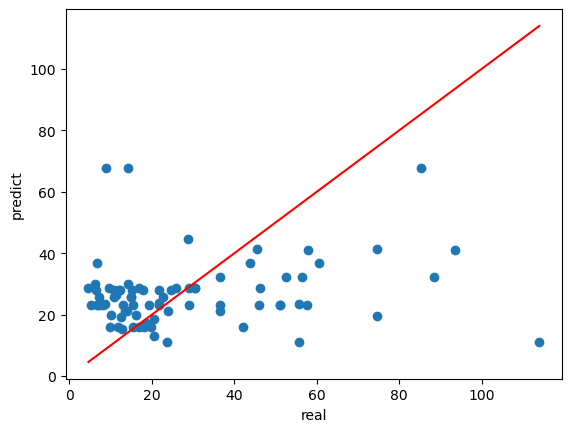

In [46]:
# 최적의 모델을 평가합니다
predictions = best_ada.predict(X_test)

# 산점도를 그립니다
plt.scatter(y_test, predictions)
plt.xlabel('real')
plt.ylabel('predict')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r') 
plt.show()

## LGBMRegressor

In [47]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_lgb, best_params_lgb = grid_search(X_train, y_train, "LGBMRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_lgb = tr_lgb(X_train, y_train, **best_params_lgb)

# 최적의 모델을 평가합니다
evaluate(best_lgb, X_test, y_test)

ValueError: Invalid model name

## GradientBoostingRegressor

In [48]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_gbm, best_params_gbm = grid_search(X_train, y_train, "GradientBoostingRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_gbm = tr_gbm(X_train, y_train, **best_params_gbm)

# 최적의 모델을 평가합니다
evaluate(best_gbm, X_test, y_test)

MAE: 15.98493855355764
RMSE: 22.27803226707178


In [49]:
print(best_model_gbm, best_params_gbm)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=50, random_state=13) {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}


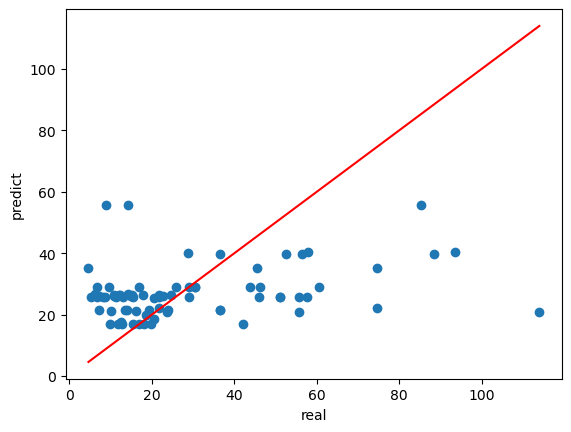

In [50]:
# 최적의 모델을 평가합니다
predictions = best_gbm.predict(X_test)

# 산점도를 그립니다
plt.scatter(y_test, predictions)
plt.xlabel('real')
plt.ylabel('predict')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r') 
plt.show()